### imports

In [ ]:
!pip install blitz-bayesian-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.8 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np

from blitz.modules import BayesianLinear, BayesianConv2d
from blitz.losses import kl_divergence_from_nn
from blitz.utils import variational_estimator

import matplotlib.pyplot as plt
import pickle

### Bayesian neural network

In [ ]:
# Hyper Parameters
input_size = 784
num_epochs = 100
batch_size = 100

transform = transforms.Compose(
         [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3015,))])

In [ ]:
class Bayesian_Neural_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = BayesianConv2d(1, 6, (5,5))
        self.conv2 = BayesianConv2d(6, 10, (5,5))
        self.fc1   = BayesianLinear(160, 110)
        self.fc2   = BayesianLinear(110, 84)
        self.fc3   = BayesianLinear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
#function for grapsh
def create_graphs(train_acc, train_loss):
  epochs_lst =list(range(1,num_epochs+1))
  plt.plot(epochs_lst , train_acc,  label= "train", color= 'purple')
  plt.title("Accuracy Value per Epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.plot(epochs_lst,train_loss , label= "train")
  plt.title("Loss Value per Epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
#function for KL calculations
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def KL_cal (neural_net):
  print(f'KL divergence is:{kl_divergence_from_nn(neural_net)}')

  params = count_parameters(neural_net)
  print(f'num of parameters is: {params}')
  print(f'KL divergence per parameter is:{kl_divergence_from_nn(neural_net)/params}')

In [ ]:
#function for Train

def train_nn(nn1, train_loader, train_dataset):
    train_count =[]
    train_loss=[]
    train_acc =[]
    train_total =0
    train_correct = 0
    train_loss_tot = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            labels = labels.to(device)
            images = images.to(device)

            #forward step
            optimizer.zero_grad()
            outputs = nn1(images)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_count.append(train_total)

            #loss
            loss = criterion(outputs, labels)
            train_loss_tot+= loss.detach().numpy()

            #backward
            loss.backward()
            optimizer.step()

            if (i+1) % 200==0:
              print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data))

        train_loss.append(train_loss_tot/train_total)
        train_acc.append(train_correct/train_total)

    create_graphs(train_acc, train_loss)

### i) Train a classifier on the full data

In [ ]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transform,
                            download=True)


# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)


Epoch [1/100], Iter [200/600] Loss: 0.3092
Epoch [1/100], Iter [400/600] Loss: 0.2240
Epoch [1/100], Iter [600/600] Loss: 0.0562
Epoch [2/100], Iter [200/600] Loss: 0.0740
Epoch [2/100], Iter [400/600] Loss: 0.0570
Epoch [2/100], Iter [600/600] Loss: 0.0565
Epoch [3/100], Iter [200/600] Loss: 0.0734
Epoch [3/100], Iter [400/600] Loss: 0.0731
Epoch [3/100], Iter [600/600] Loss: 0.0884
Epoch [4/100], Iter [200/600] Loss: 0.0394
Epoch [4/100], Iter [400/600] Loss: 0.0742
Epoch [4/100], Iter [600/600] Loss: 0.0209
Epoch [5/100], Iter [200/600] Loss: 0.0309
Epoch [5/100], Iter [400/600] Loss: 0.0634
Epoch [5/100], Iter [600/600] Loss: 0.0260
Epoch [6/100], Iter [200/600] Loss: 0.0068
Epoch [6/100], Iter [400/600] Loss: 0.0159
Epoch [6/100], Iter [600/600] Loss: 0.0311
Epoch [7/100], Iter [200/600] Loss: 0.0372
Epoch [7/100], Iter [400/600] Loss: 0.0053
Epoch [7/100], Iter [600/600] Loss: 0.0414
Epoch [8/100], Iter [200/600] Loss: 0.0187
Epoch [8/100], Iter [400/600] Loss: 0.0006
Epoch [8/10

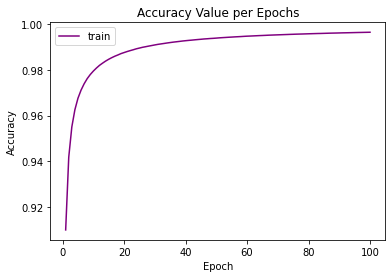

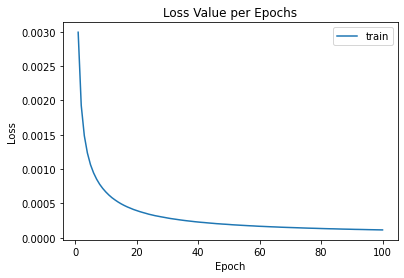

KL divergence is:206335.96875
num of parameters is: 118200
KL divergence per parameter is:1.745651125907898


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn1 = Bayesian_Neural_Network().to(device)
optimizer = optim.Adam(nn1.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_nn(nn1, train_loader, train_dataset)
KL_cal(nn1)

with open("train_hw1_206238891_fulldataset.pkl", "wb") as f:
     pickle.dump(nn1, f)


### ii) Train a classifier on the first 200 samples of Mnist

In [ ]:
# MNIST Dataset (Images and Labels)
train_dataset200 = dsets.MNIST(root='./data',
                            train=True,
                            transform=transform,
                            download=True)

In [ ]:
#select 200 first samples
lst = list(range(0, 200))
trainset_200 = torch.utils.data.Subset(train_dataset200, lst)

# Dataset Loader (Input Pipline)
train_loader200 = torch.utils.data.DataLoader(dataset=trainset_200,
                                           batch_size=batch_size,
                                           shuffle=True)

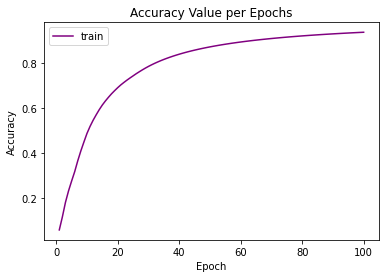

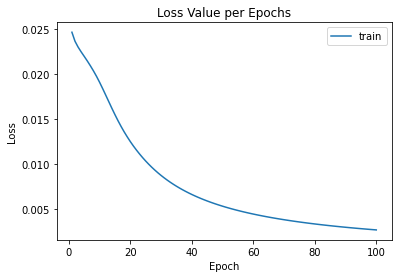

KL divergence is:138362.6875
num of parameters is: 118200
KL divergence per parameter is:1.1705811023712158


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_200_samples = Bayesian_Neural_Network().to(device)
optimizer = optim.Adam(nn_200_samples.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_nn(nn_200_samples, train_loader200, trainset_200)
KL_cal(nn_200_samples)

with open("train_hw1_206238891_200.pkl", "wb") as f:
     pickle.dump(nn_200_samples, f)


### iii)Train a classifier on the 200 first '3' and '8'

In [ ]:
# MNIST Dataset (Images and Labels)
train_dataset200_83 = dsets.MNIST(root='./data',
                            train=True,
                            transform=transform,
                            download=True)

In [ ]:
#choose only 3 and 8
images = train_dataset200_83.data
labels = train_dataset200_83.targets

train_filter = np.where((labels == 8) | (labels == 3))
train_dataset200_83.data = images[train_filter]
train_dataset200_83.targets = labels[train_filter]

#select 200 first samples
lst = list(range(0, 200))
trainset_200_83 = torch.utils.data.Subset(train_dataset200_83, lst)

# Dataset Loader (Input Pipline)
train_loader200_83 = torch.utils.data.DataLoader(dataset=trainset_200_83,
                                           batch_size=batch_size,
                                           shuffle=True)


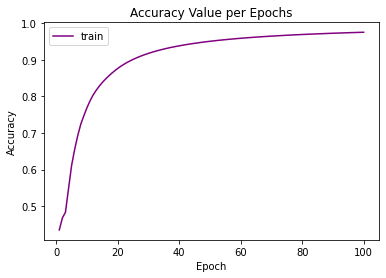

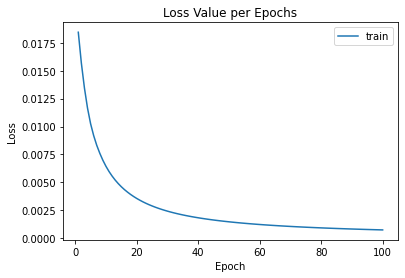

KL divergence is:137690.109375
num of parameters is: 118200
KL divergence per parameter is:1.1648908853530884


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_200_83 = Bayesian_Neural_Network().to(device)
optimizer = optim.Adam(nn_200_83.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_nn(nn_200_83, train_loader200_83,trainset_200_83)
KL_cal(nn_200_83)

with open("train_hw1_206238891_200_38.pkl", "wb") as f:
     pickle.dump(nn_200_83, f)

### iv)Train a classifier on all '3' and '8'

In [ ]:
# MNIST Dataset (Images and Labels)
train_dataset38 = dsets.MNIST(root='./data',
                            train=True,
                            transform=transform,
                            download=True)


In [ ]:
#choose only 3 and 8
images = train_dataset38.data
labels = train_dataset38.targets

train_filter = np.where((labels == 8) | (labels == 3))
train_dataset38.data = images[train_filter]
train_dataset38.targets = labels[train_filter]


In [ ]:
# Dataset Loader (Input Pipline)
train_loader38 = torch.utils.data.DataLoader(dataset=train_dataset38,
                                           batch_size=batch_size,
                                           shuffle=True)

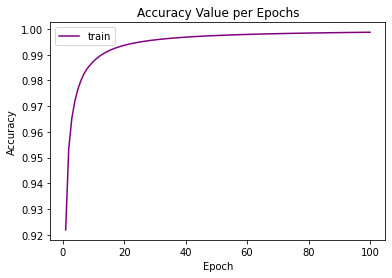

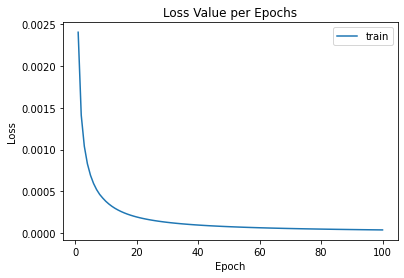

KL divergence is:139836.03125
num of parameters is: 118200
KL divergence per parameter is:1.1830459833145142


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_38 = Bayesian_Neural_Network().to(device)
optimizer = optim.Adam(nn_38.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


train_nn(nn_38, train_loader38, train_dataset38)
KL_cal(nn_38)

with open("train_hw1_206238891_38.pkl", "wb") as f:
     pickle.dump(nn_38, f)

### v)With Rnadomization - Train on the first 200 samples, random labels

In [ ]:
# MNIST Dataset (Images and Labels)
train_dataset_rnd = dsets.MNIST(root='./data',
                            train=True,
                            transform=transform,
                            download=True)

In [ ]:
#Generate random labels

rnd_train = torch.rand(len(train_dataset_rnd))
rnd_train.apply_(lambda x: 1 if (x>=0.5) else 0)
rnd_train = rnd_train.type(torch.LongTensor)

images = train_dataset_rnd.data
train_dataset_rnd.data = images
train_dataset_rnd.targets = rnd_train


In [ ]:
#select 200 first samples
lst = list(range(0, 200))
trainset_200_rnd = torch.utils.data.Subset(train_dataset_rnd, lst)


In [ ]:
# Dataset Loader (Input Pipline)
train_loader_rnd = torch.utils.data.DataLoader(dataset=trainset_200_rnd ,
                                           batch_size=batch_size,
                                           shuffle=True)

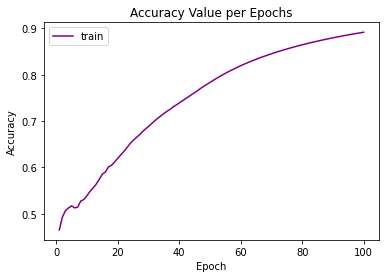

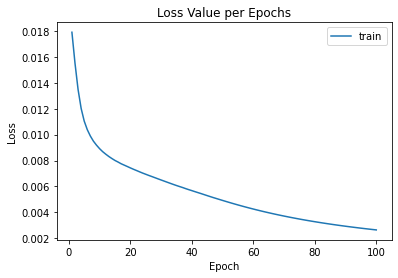

KL divergence is:138663.78125
num of parameters is: 118200
KL divergence per parameter is:1.1731284856796265


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_random = Bayesian_Neural_Network().to(device)
optimizer = optim.Adam(nn_random.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_nn(nn_random,train_loader_rnd ,trainset_200_rnd)
KL_cal(nn_random)

with open("train_hw1_206238891_rnd.pkl", "wb") as f:
     pickle.dump(nn_random, f)